# 第四次个人作业（时间数据分析 + 图像数据分析 + 文本数据分析，满分15分）

### 第一部分：时间数据分析（本部分满分5分）

请使用2010-2014年北京市天气和空气污染数据（air_pollution.csv），完成以下各题。

In [67]:
import pandas as pd
import datetime
import time
df = pd.read_csv('air_pollution.csv',
                           parse_dates=True, index_col=0)

1.1 请按照每周（每周第一天为周一，最后一天为周日）对空气污染指数（即pollution_today列）做聚合，聚合的方式为平均值，并将结果进行可视化。（聚合2分，可视化1分）

In [68]:
day_pol = df['pollution_today']
week_pol = day_pol.resample('1W-Mon', closed='left').mean()

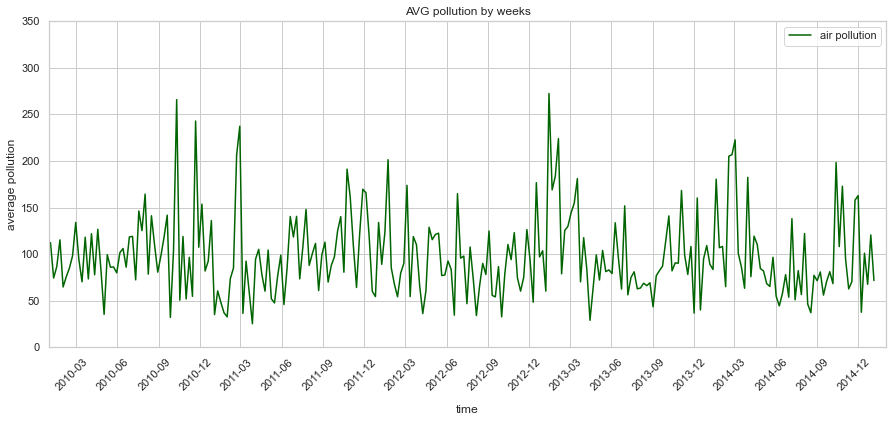

In [105]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

x = week_pol.index
y = week_pol 

left = datetime.date(2010, 1, 1)
right = datetime.date(2015, 2,1)
sns.set(style="whitegrid")

fig, ax = plt.subplots(figsize=(15, 6)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m\n')) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
ax.tick_params(axis='x', labelrotation=45)
#ax.xaxis.set_xlim(timestamp('2010-01'))
ax.axes.set_xlim(left,right)
ax.axes.set_ylim(0,350)
ax.set_xlabel('time')

ax.set_ylabel('average pollution')
ax.set_title('AVG pollution by weeks')
ax.plot(x,y,color='darkgreen',label='air pollution')
ax.legend()
plt.show()


1.2 请对风速（wnd_spd）和当天污染程度（pollution_today）两列做【简单】的相关性分析，并进行简单的可视化。做可视化时，请不要超过两个图表。（1分）

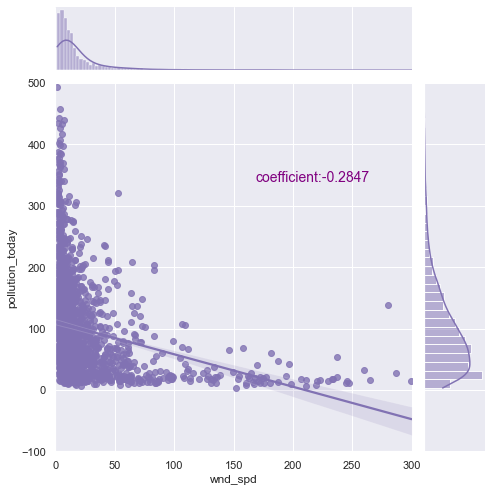

In [130]:
import numpy as np
x = df.wnd_spd
y = df.pollution_today
sns.set(style="darkgrid")
sns.jointplot(data=df, x="wnd_spd", y="pollution_today",kind= "reg", truncate=False
              ,xlim=(0, 300), ylim=(-100, 500),
                color="m", height=7)

pccs = np.corrcoef(x, y)
coef= 'coefficient:%.4f' % pccs[1,0]

plt.text(-650,340,coef,fontsize=14,color='purple')

plt.show()



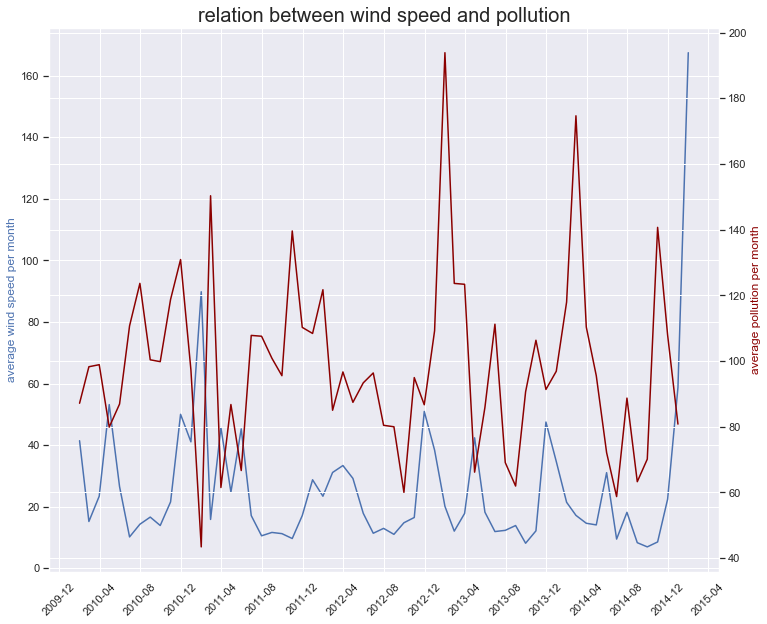

In [103]:
wnd_mon = df['wnd_spd'].resample('M', closed='left').mean()
pol_mon = df.pollution_today.resample('M').mean()

fig, ax1 = plt.subplots(figsize=(12,10))
newdate1 = pd.to_datetime(wnd_mon.index)
newdate2 = pd.to_datetime(pol_mon.index)

plt.title('relation between wind speed and pollution',fontsize=20)
ax1.set_ylabel('average wind speed per month',color='b')

ax1.plot(newdate1,wnd_mon.values)

ax2 = ax1.twinx()
ax2.set_ylabel('average pollution per month',color='darkred')
ax2.plot(newdate2,pol_mon.values,color='darkred')


fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
fig.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
#fig.gca().set_xtick()
ax1.tick_params(axis='x', labelrotation=45)

plt.show()
#pol_mon.plot()

1.3 除了空气污染情况外，本数据集还给出了湿度（dew）、温度（temp）、气压（press）、风速（wnd_spd）、降雪量（snow）、降雨量（rain）等时间序列数据。你认为如何能够使用此数据更好地预测空气污染情况？（1分，不超过300字）

因为变量较多，我认为可以用向量回归模型找出時間和這些變量之間的關係。
而在参数设定上可以给不同变量不同的权重，至于如何设定权重我会用以下方法：先观察每个变量与空气污染之间的关系，先算出每个变量和**空气污染的相关系数**。另外观察是否有**季节性**等规律。

另外，我认为在分析上因为时间跨度是好几年，用移动平均或者权重移动平均更能反应现况（**因为每个季节可能有不同的合理平均，这样预测会更加准确，比如预测夏天的数据的时候就应该将降雪量这个变量的权重设低一些甚至设为零直接排除**）。甚至Exponential Smoothing 会更合适（Exponential Smoothing 的核心思想在于越久以前的时间点，权重会呈指数衰减。

### 第二部分：图像数据分析（本部分满分5分）

2.1 利用fetch_openml读取"mnist_784"数据集，计算并展示数据集中的每个类别（0-9）的平均形态。（1.5分）

In [133]:
from sklearn import datasets 

# Turn down for faster convergence
t0 = time.time()
train_samples = 5000

# Load data from https://www.openml.org/d/554
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

/Users/ah/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

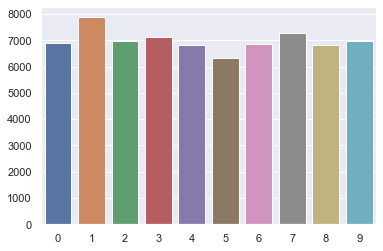

In [162]:
num_cnt = []
for i in range(0,10):
    num_cnt.append(np.sum(y==str(i)))
    
sns.barplot([0,1,2,3,4,5,6,7,8,9],num_cnt)

2.2 利用sklearn中的MLPClassifier构建神经网络，对"mnist_784"数据集进行分类，要求： 

- 在验证集上选出最优模型。（0.5分）
- 并在测试集上计算各模型的预测结果，并进行模型结果评价。（0.5分）


- 按照7:2:1的比例，依据类别分层抽样，将数据划分为训练集（train_set）、验证集（dev_set）和测试集（test_set）。（1分）

In [165]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.875)

print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)

(49000, 784)
(14000, 784)
(7000, 784)


- 构建单隐层神经网络（隐藏层参数自设）。（1分）
- 在训练集上训练神经网络及其他2个自选分类模型。（0.5分）

In [179]:
mlp_a = MLPClassifier(solver='sgd',hidden_layer_sizes=(784, ))
mlp_b = MLPClassifier(solver='adam',hidden_layer_sizes=(500,))
mlp_c = MLPClassifier(solver='sgd',batch_size=1000,shuffle=False)

# 将验证集和训练集合并
x_training_data_final = np.vstack((X_train,X_valid))
y_training_data_final = np.append(y_train,y_valid)

model_a = mlp_a.fit(x_training_data_final, y_training_data_final)
model_b = mlp_b.fit(x_training_data_final, y_training_data_final,)
model_c = mlp_c.fit(x_training_data_final, y_training_data_final)

/Users/ah/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [185]:
print(model_a.score(X_test,y_test),model_a.loss_)
print(model_b.score(X_test,y_test))
print(model_c.score(X_test,y_test))

0.9620714285714286 0.0018717093376318945
0.9778571428571429
0.9352142857142857


### 第三部分：文本数据分析（本部分满分5分）

3.1 什么是自动文摘（也称为自动摘要）？自动文摘一般可以分成哪两类？（1分）

自动文摘是利用计算机自动从原始文献中提取可以反映文章中心思想的简单短文（文摘）的技术。

自动文摘技术主要分为抽取式摘要（extractive summarization）和生成式摘要（abstractive summarization）两类。前者利用不同文档结构单元（句子、段落等）进行评价，对每个结构单元赋予一定权重然后选择最重要的结构单元组成摘要。后者通常需要利用自然语言理解技术对文本进行语法、语义分析，对信息进行融合，利用自然语言生成技术新的摘要句子，又称为理解性文摘。

3.2 收集近五年（2018-2022）政府工作报告全文，绘制词云，并分析政府工作重点的保持与变化，要求：
- 合理设置停用词，提升词云的可读性与区分度（2分）
- 结合外部统计数据或分析报告，对每年的重点和变化进行分析解释（不超过400字，言之成理即可，2分）

In [424]:
import textract
doclist = []

doclist.append(textract.process("18doc.docx").decode("utf-8"))
doclist.append(textract.process("19doc.docx").decode("utf-8"))
doclist.append(textract.process("20doc.docx").decode("utf-8"))
doclist.append(textract.process("21doc.docx").decode("utf-8"))
doclist.append(textract.process("22doc.docx").decode("utf-8"))

stopwords = set()
content = [line.strip() for line in open('HIT_stopwords.txt','r').readlines()]
content2 = [line.strip() for line in open('SCU_stopwords.txt','r').readlines()]
stopword_custmomize = ['今年','工作','达到','实施','不','超过','主要','报告','加大','国务院','年','完成','取得','促进','加强',
                       '更','政府','一批','减少','我国','推动','提高','实现','重大','中国','中','好','以上','各项']
stopwords.update(content,content2,stopword_custmomize)


In [417]:
def wordcloudGenerator(text):
    #plt.figure(figsize=(8,8))
    sns.set(style='white')
    text = text.replace('\n','').replace('\xa0','').replace(' ','')
    cut_word = " ".join(jieba.cut(text))
    wc = WordCloud(font_path = r'AaShiSongTi-2.ttf',
              stopwords = stopwords,background_color='Black',
              relative_scaling=0.2,
              width=700,height=200,
              max_font_size=72,
              max_words=180,
             
              collocations=True, 
              random_state=10,
              colormap='OrRd_r')
    wc.generate(cut_word)
    return wc
    

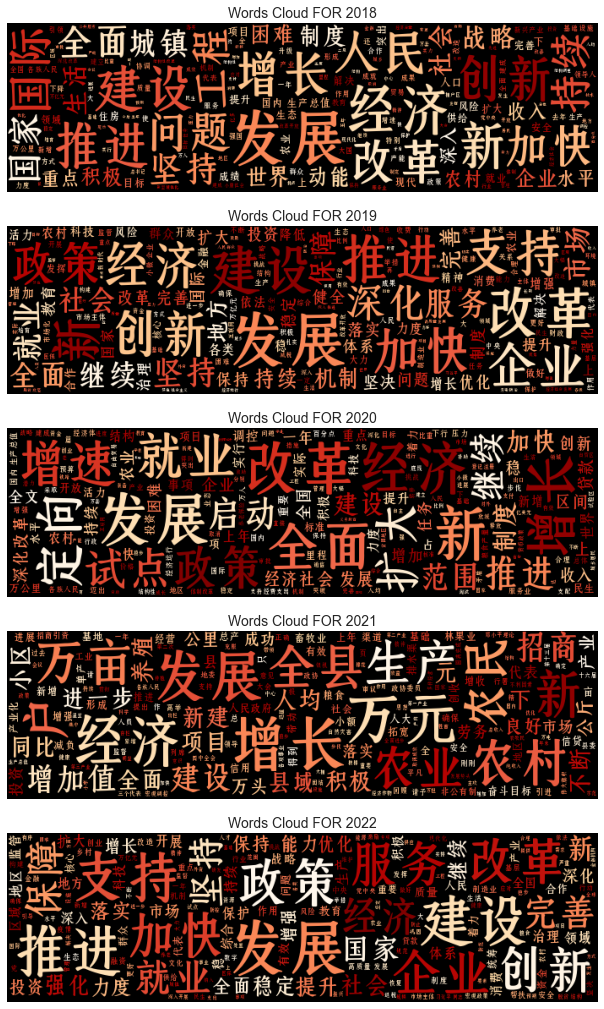

In [425]:
import jieba
from wordcloud import WordCloud
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(len(doclist),1,figsize=(12,18))

for i in range(0,len(doclist)):
    year = i+18
    ax[i].set_title('Words Cloud FOR 20%s'%year,fontsize=14)
    ax[i].axis('off')
    ax[i].imshow(wordcloudGenerator(doclist[i]))





从词云发现政府工作报告的形质是面向全国的，因为屡屡提到“全国”、“全面”、“国家”等词，另外也会发现“增长”、“加快”、“扩大”、“发展”等积极每年都会出现，还有“坚持”、“持续”、“继续等代表长期计划的词汇，可以得知政府方针主基调是追求进步的积极态度与长远心态。另外，改革、创新、新这三个词也常常出现，可以从中知道政府近年的态度。
综观来看，政府方针也多围绕在经济上，“经济”、“企业”为每年都会出现的词，就业、人口、市场也是方针重点，这也符合各界对中国发展政策的解读。
比较特别的是2021年的重点特别放在“农村”、“农民”、“县域”上。另外2022年中“稳定”、“保障”、“保护”出现的频次比前几年都多。我推测是这几年国际局势动荡较大，另外受到疫情冲击，政府采取比较追求稳定与安稳国内状况，另外“服务”一词也首次较为频繁的出现，或许代表的是一经济侧重点与商业型态的转型。
比较令我意外的点是“新冠”、“疫情”、“贸易”、“外交”、“中美”等词并没有频繁的出现。另外，在我修的“中国经济专题”课程中，老师提到中国经济数十年来一直追求的是GDP增长，也讨论了许多经济学家不断提倡市场化的争论。政府工作报告中可以看见“改革”、“市场”等词，算是能够呼应老师讲述的内容，但并没有提到国民生产总额(GDP)是令我比较意外的部分。
